# Training of DDPM（Denoising Diffusion Probabilistic Models)
# 去噪扩散概率模型训练

In [1]:
%%capture
# 安装训练支持版本
!pip install diffusers[training]==0.11.1

# 安装Git-LFS 上传模型检查点
# %%capture
# !sudo apt -qq install git-lfs
# !git config --global credential.helper store

## 1.超参数

In [2]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 150
    gradient_accumulation_steps = 1
    learning_rate = 1.5e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = '/root/diffusers_main/output/'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

## 2.数据集加载与处理

In [3]:
from datasets import load_dataset

config.dataset_name = "/root/autodl-tmp/Cityscapes_C/train/"
dataset = load_dataset(config.dataset_name, split="train")

Resolving data files:   0%|          | 0/9900 [00:00<?, ?it/s]

In [4]:
dataset

Dataset({
    features: ['image'],
    num_rows: 9900
})

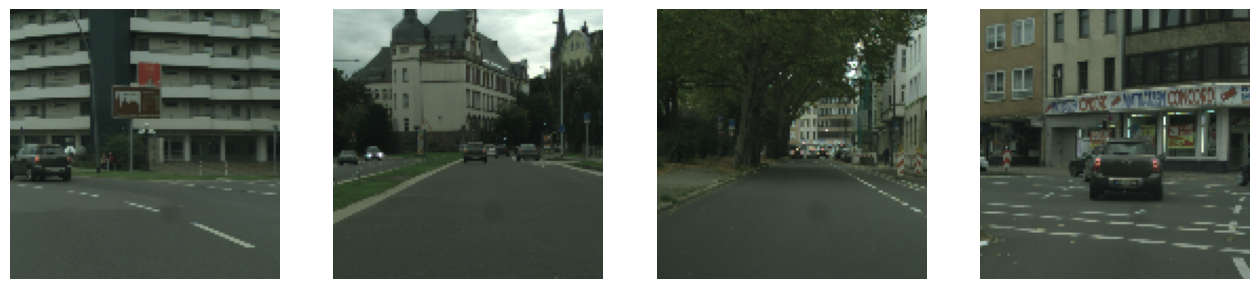

In [5]:
import matplotlib.pyplot as plt
from torchvision import transforms
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:8]["images"]):
    if i % 2 == 0:
        axs[i // 2].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
        axs[i // 2].set_axis_off()

fig.show()

## 3.模型架构
Unet网络

In [6]:
import torch
from diffusers import UNet2DModel

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

输入输出格式: 

In [7]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


根据使用的扩散算法，图像加噪的方式略有不同。 

Diffusers 包含不同的调度程序类，每个调度程序类都定义特定于算法的扩散步骤。 

这里我们将使用 DDPMScheduler，它对应于 Denoising Diffusion Probabilistic Models 中提出的训练去噪和训练算法。

In [8]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

噪声调度器是如何工作的：

它从trainng集中获取一批图像（这里我们将重用之前的一批图像sample_image形式），一批相同形状的随机噪声以及每个图像的时间步长（其中 对应于我们想要对每个图像应用噪声的次数）：

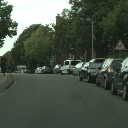

Input shape: torch.Size([1, 3, 128, 128])


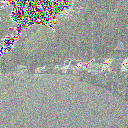

In [9]:
import torch
from torchvision import transforms
from PIL import Image

to_tensor = transforms.Compose([
    transforms.ToTensor(),
])

img = Image.open('/root/autodl-tmp/Cityscapes_C/test/munster_000124_000019_leftImg8bit_0.png')
img.show()
sample_image = to_tensor(img).unsqueeze(0)
print('Input shape:', sample_image.shape)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# 将图片像素值[-1,1]映射到[0,255]
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

## 模型训练

In [10]:
import torch.nn.functional as F

model_path = "/root/diffusers_main/output/unet/"
model = UNet2DModel.from_pretrained(model_path)

# 在DDPM算法中，模型的训练目标是能够预测在noise_scheduler.add_noise中使用的噪声，
# 因此这一步的损失将是：
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
# 使用标准 AdamW 优化器：
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
from diffusers.optimization import get_cosine_schedule_with_warmup
# 使用余弦学习率表：
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

为了评估我们的模型，我们使用 DDPMPipeline，这是执行端到端推理的简单方法。 我们将使用这个pipe生成一批样本图像并将其作为网格保存到本地。

In [11]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # 从随机噪声中采样一些图像（这是后向扩散过程）。
    # 默认pipe输出类型是 `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # 用图像制作网格
    image_grid = make_grid(images, rows=4, cols=4)

    # 保存图像
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")



最后，我们可以将所有内容组合在一起并编写我们的训练函数。 

将训练步骤包装在一个循环中，使用 Accelerate 进行梯度累积、混合精度训练以及多 GPU 或 TPU 训练。

In [12]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # 初始化加速器
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps
        # log_with="tensorboard", # TensorBoard 日志记录
        # logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            # repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # 训练模型
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # 添加到图像的样本噪声
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # 对每张图像进行随机时间步采样
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # 根据每个时间步的噪声大小向干净图像添加噪声
            # （这是前向扩散过程）
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # 在每个epoch之后，选择使用evaluate（）对一些演示图像进行采样并保存模型
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1 or epoch==0:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

开始训练

In [ ]:
from accelerate import notebook_launcher
# args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
# notebook_launcher(train_loop, args, num_processes=1)
model.train()
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/619 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/diffusers/pipelines/ddpm/pipeline_ddpm.py:89: FutureWarning: `generator.device == 'cpu'` is deprecated and will be removed in version 0.12.0. The `generator` device is `cpu` and does not match the pipeline device `cuda:0`, so the `generator` will be ignored. Please use `torch.Generator(device="cuda:0")` instead.
  deprecate(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/619 [00:00<?, ?it/s]

经过训练的扩散模型生成的最终图像表:

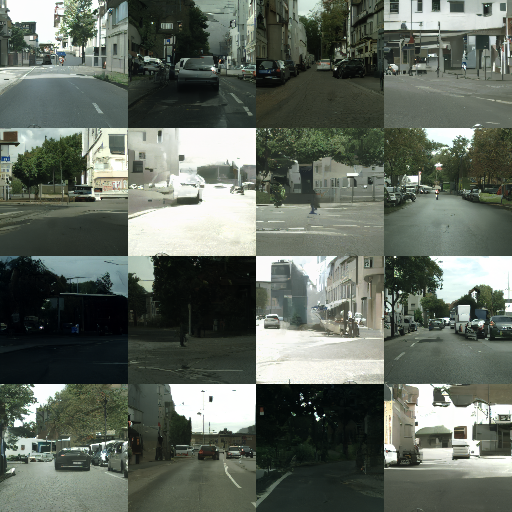

In [3]:
import glob
from PIL import Image
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])